In [1]:
##Ridge regression 

import os
import matplotlib.pyplot as plt
import numpy as np
import scripts.implementations as lib  # Add personal library
import scripts.proj1_helpers as helper  # Add personal library

%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4)

DATA_FOLDER = 'data'
DATA_TRAIN = os.path.join(DATA_FOLDER, 'train.csv')
DATA_TEST = os.path.join(DATA_FOLDER, 'test.csv')

y, x, ids, header = helper.load_csv_data(DATA_TRAIN)
y_train, x_train,  y_validation, x_validation = lib.sep_valid_train_data(x,y, 0.8);
print(y_train.shape)

(200000,)


In [2]:
x_train[x_train == -999] = np.nan
x_validation[x_validation == -999] = np.nan

In [3]:
for i, feature in enumerate(x_train.T):
    print('Feature {} - {} has range: [{:.4f}, {:.4f}]'.format(
        i+1, header[i], np.nanmin(feature), np.nanmax(feature)))

Feature 1 - DER_mass_MMC has range: [9.0440, 1192.0260]
Feature 2 - DER_mass_transverse_met_lep has range: [0.0000, 595.8190]
Feature 3 - DER_mass_vis has range: [6.4620, 1329.9130]
Feature 4 - DER_pt_h has range: [0.0000, 1053.8070]
Feature 5 - DER_deltaeta_jet_jet has range: [0.0000, 8.5030]
Feature 6 - DER_mass_jet_jet has range: [13.6020, 4974.9790]
Feature 7 - DER_prodeta_jet_jet has range: [-18.0660, 16.6900]
Feature 8 - DER_deltar_tau_lep has range: [0.2080, 5.6840]
Feature 9 - DER_pt_tot has range: [0.0000, 513.6590]
Feature 10 - DER_sum_pt has range: [46.1040, 1852.4620]
Feature 11 - DER_pt_ratio_lep_tau has range: [0.0470, 19.7730]
Feature 12 - DER_met_phi_centrality has range: [-1.4140, 1.4140]
Feature 13 - DER_lep_eta_centrality has range: [0.0000, 1.0000]
Feature 14 - PRI_tau_pt has range: [20.0000, 622.8620]
Feature 15 - PRI_tau_eta has range: [-2.4990, 2.4970]
Feature 16 - PRI_tau_phi has range: [-3.1420, 3.1420]
Feature 17 - PRI_lep_pt has range: [26.0000, 461.8960]
Fea

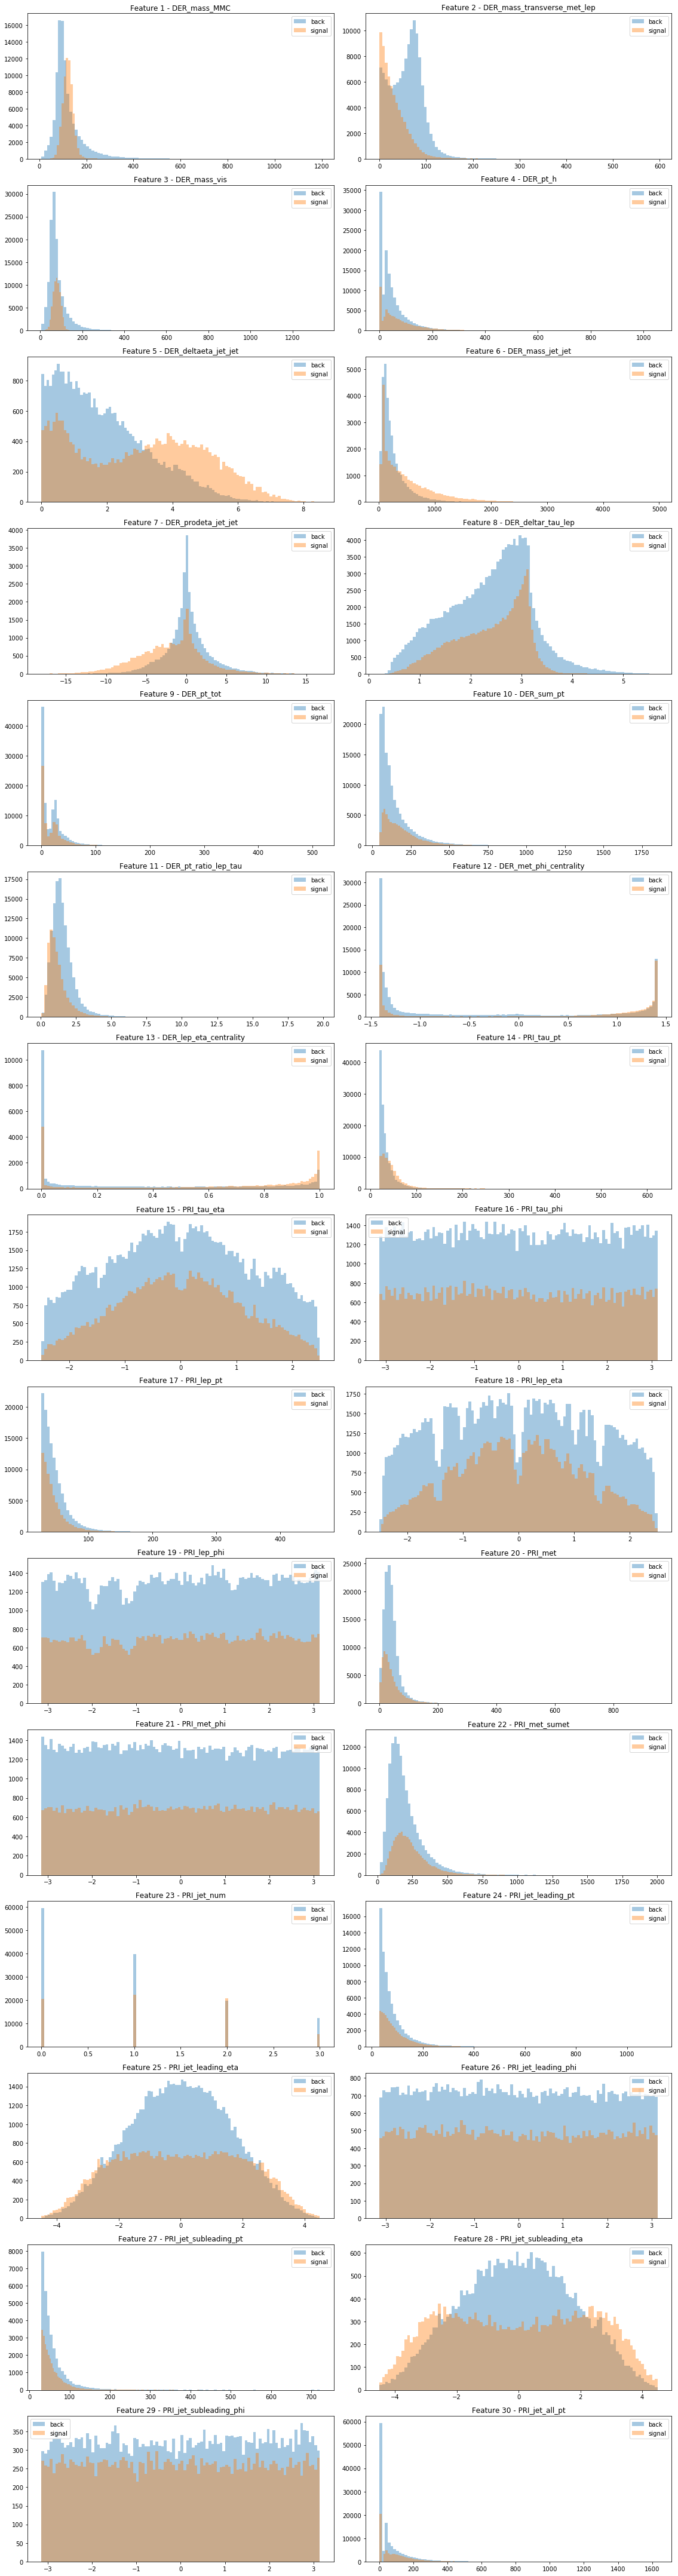

In [70]:
plt.figure(figsize=(16,60))

for i, feature in enumerate(x_train.T):
    plt.subplot(15, 2, i+1)
    id_keep = ~np.isnan(feature)
    id_b = np.logical_and(y_train == -1, id_keep)
    id_s = np.logical_and(y_train == 1, id_keep)
    #plt.hist(feature[id_keep], bins=100, alpha=0.4, label='total')
    plt.hist(feature[id_b], alpha=0.4, bins=100, label='back')
    plt.hist(feature[id_s], alpha=0.4, bins=100, label='signal')
    plt.title('Feature {} - {}'.format(i+1, header[i]))
    plt.legend()
plt.tight_layout()

In [4]:
# Remove features with NaN
keep_id = np.nonzero(np.sum(np.isnan(x_train), axis=0) == 0)[0]
x_naive = x_train[:, keep_id]
# normalize features
x_naive = (x_naive - np.mean(x_naive, axis=0))/np.std(x_naive, axis=0)

keep_id_val = np.nonzero(np.sum(np.isnan(x_validation), axis=0) == 0)[0]
x_naive_val = x_validation[:, keep_id]
# normalize features
x_naive_val = (x_naive_val - np.mean(x_naive_val, axis=0))/np.std(x_naive_val, axis=0)

In [ ]:
from scripts.ml import cross_validation_ls

degrees = np.linspace(1, 6, 6).astype(int)
for i, degree in enumerate(degrees):
    acc, _, _ = cross_validation_ls(y_train, x_naive, degree=degree)
    print('{}/{} Least square deg {} with acc {:.4f}'.format(i+1, len(degrees), degree, acc))

In [5]:
def plot_train_test(train_errors, test_errors, lambdas, degree):
    """
    train_errors, test_errors and lambas should be list (of the same size) the respective train error and test error for a given lambda,
    * lambda[0] = 1
    * train_errors[0] = RMSE of a ridge regression on the train set
    * test_errors[0] = RMSE of the parameter found by ridge regression applied on the test set
    
    degree is just used for the title of the plot.
    """
    plt.semilogx(lambdas, train_errors, color='b', marker='*', label="Train error")
    plt.semilogx(lambdas, test_errors, color='r', marker='*', label="Test error")
    plt.xlabel("lambda")
    plt.ylabel("RMSE")
    plt.title("Ridge regression for polynomial degree " + str(degree))
    leg = plt.legend(loc=1, shadow=True)
    leg.draw_frame(False)
    plt.savefig("ridge_regression")
    
def test_ridge_regression(x, y, x_val, y_val, degrees, lambdas):
    
    best_acc = 0
    best_degree = 0
    best_lambda = 0
    best_rmse_tr = []
    best_rmse_te = []
    best_weights = []
    for degree in degrees:
        degree = int(degree)
        #lambdas = np.logspace(-7, 2, 20)

        # Split sets
        #x_train, x_test, y_train, y_test = split_data(x, y, ratio, seed)

        # Get ploynomial
        phi_train = lib.build_poly(x, degree)
        phi_test = lib.build_poly(x_val, degree)

        rmse_tr = []
        rmse_te = []
        update_rmse = False

        for ind, lambda_ in enumerate(lambdas):

            mse_tr, weights = lib.ridge_regression(y, phi_train, lambda_)
            mse_te = lib.compute_loss(y_val, phi_test.dot(weights))
            rmse_tr.append(np.sqrt(2*mse_tr))
            rmse_te.append(np.sqrt(2*mse_te))

            print("degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                    d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
            print('train acc : ', lib.accuracy(y, phi_train.dot(weights)))
            val_acc = lib.accuracy(y_val, phi_test.dot(weights))
            print('validation acc : ', val_acc)

            if(val_acc > best_acc):
                best_acc = val_acc
                best_degree = degree
                best_lambda = lambda_
                best_weights = weights
                update_rmse = True
        
        if(update_rmse):
            best_rmse_tr = rmse_tr
            best_rmse_te = rmse_te

        # Plot the best obtained results
    plot_train_test(best_rmse_tr, best_rmse_te, lambdas, best_degree)

    print('Best params for Ridge regression : degree = ',best_degree, ', lambda = ',best_lambda,', accuracy = ', best_acc)
    
    return best_weights, best_degree, best_lambda

In [ ]:
weights_naive = test_ridge_regression(x_naive, y_train, x_naive_val, y_validation, degrees = np.linspace(1,5,5), lambdas=np.logspace(-7,2,20))

## Ridge with no_nan


In [36]:
def mad(x_feat):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation 
    """
    mad_res = np.ones(x_feat.shape[1])
    for i, col in enumerate(x_feat.T):
        arr = np.ma.array(col).compressed() # should be faster to not use masked arrays.
        med = np.nanmedian(arr)
        mad_res[i] = np.nanmedian(np.abs(arr - med))

    return mad_res

def normalize_outliers(x_in, n_std=2.5):
    # 1. Substract mean
    # 2. Compute std and detect ouliers
    # 3. Compute std and mean witout ouliers
    mean_corr = []
    std_corr = []
    
    for i, feat in enumerate(x_in.T):
        # Substract mean
        feat_cent = feat-np.nanmean(feat)
        # Get threshold
        std_thresh = np.nanstd(feat_cent, axis=0)
        # Substract new mean
        mean_update = np.nanmean(feat[feat_cent < n_std*std_thresh])
        std_update = np.nanstd(feat[feat_cent < n_std*std_thresh])
        x_in[:, i] = feat-mean_update
        x_in[feat > n_std*std_thresh, i] = n_std*std_thresh
        x_in[feat < -n_std*std_thresh, i] = -n_std*std_thresh
        x_in[:, i] = x_in[:, i]/std_update
        mean_corr.append(mean_update)
        std_corr.append(std_update)
    return x_in, mean_corr, std_corr

def normalize_outliers_feed(x_in, mean_ref, std_ref, n_std=2.5):
    # 1. Substract mean
    # 2. Compute std and detect ouliers
    # 3. Compute std and mean witout ouliers
    for i, feat in enumerate(x_in.T):
        x_in[:, i] = feat-mean_ref[i]
        x_in[feat > n_std*std_ref[i], i]  = n_std*std_ref[i]
        x_in[feat < -n_std*std_ref[i], i] = -n_std*std_ref[i]
        x_in[:, i] = x_in[:, i]/std_ref[i]
    return x_in


x_no_nan = x_train.copy()
x_no_nan, mean_train, std_train = normalize_outliers(x_no_nan)
# x_no_nan = (x_no_nan - np.nanmean(x_no_nan, axis=0))/np.nanstd(x_no_nan, axis=0)
x_no_nan = np.nan_to_num(x_no_nan)
print('\nStd:', np.std(x_no_nan, axis=0))

# normalize features
x_no_nan_val = x_validation.copy()
x_no_nan_val = normalize_outliers_feed(x_no_nan_val, mean_train, std_train)
# x_no_nan_val = (x_no_nan_val - np.nanmean(x_no_nan_val, axis=0))/np.nanstd(x_no_nan_val, axis=0)
x_no_nan_val = np.nan_to_num(x_no_nan_val)
print('\nStd:', np.std(x_no_nan_val, axis=0))

# normalize features
#x_no_nan = x_train.copy()
#x_no_nan = (x_no_nan - np.nanmean(x_no_nan, axis=0))/np.nanstd(x_no_nan, axis=0)
#x_no_nan = np.nan_to_num(x_no_nan)
#print('\nStd:', np.std(x_no_nan, axis=0))

# normalize features
#x_no_nan_val = x_validation.copy()
#x_no_nan_val = (x_no_nan_val - np.nanmean(x_no_nan_val, axis=0))/np.nanstd(x_no_nan_val, axis=0)
#x_no_nan_val = np.nan_to_num(x_no_nan_val)
#print('\nStd:', np.std(x_no_nan_val, axis=0))


# normalize features
#x_no_nan = x_train.copy()
#x_no_nan = (x_no_nan - np.nanmedian(x_no_nan, axis=0))/mad(x_no_nan)
#x_no_nan = np.nan_to_num(x_no_nan)
#print('\nStd:', mad(x_no_nan))

# normalize features
#x_no_nan_val = x_validation.copy()
#x_no_nan_val = (x_no_nan_val - np.nanmedian(x_no_nan_val, axis=0))/mad(x_no_nan_val)
#x_no_nan_val = np.nan_to_num(x_no_nan_val)
#print('\nStd:', mad(x_no_nan_val))

/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in less
/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in less



Std: [ 1.074   1.0408  1.1532  1.1364  0.5519  0.6304  0.5432  1.0183  1.1146
  1.1341  1.1064  1.      0.5399  1.1454  1.      1.      1.1456  1.      1.
  1.1392  1.      1.1057  1.      0.89    0.7756  0.7753  0.6201  0.5399
  0.5399  1.1287]

Std: [ 0.9387  1.0269  1.0202  1.0389  0.5445  0.5482  0.5311  1.0152  1.0284
  1.0336  1.0361  1.0038  0.5337  1.0106  1.0017  1.0002  1.0205  1.0049
  1.0041  1.0317  0.9975  1.043   0.9936  0.801   0.7736  0.7704  0.5433
  0.5313  0.5326  1.0313]


degree=9, lambda=0.000, Training RMSE=0.729, Testing RMSE=0.733
train acc :  0.822195
validation acc :  0.8202
degree=9, lambda=0.000, Training RMSE=0.729, Testing RMSE=0.733
train acc :  0.822185
validation acc :  0.82028
degree=9, lambda=0.000, Training RMSE=0.729, Testing RMSE=0.733
train acc :  0.822205
validation acc :  0.82026
degree=9, lambda=0.000, Training RMSE=0.729, Testing RMSE=0.733
train acc :  0.822185
validation acc :  0.82026
degree=9, lambda=0.000, Training RMSE=0.729, Testing RMSE=0.733
train acc :  0.82219
validation acc :  0.8203
degree=9, lambda=0.000, Training RMSE=0.729, Testing RMSE=0.733
train acc :  0.822245
validation acc :  0.8202
degree=9, lambda=0.000, Training RMSE=0.729, Testing RMSE=0.733
train acc :  0.82224
validation acc :  0.82024
degree=9, lambda=0.000, Training RMSE=0.729, Testing RMSE=0.733
train acc :  0.82224
validation acc :  0.82026
degree=9, lambda=0.000, Training RMSE=0.729, Testing RMSE=0.733
train acc :  0.82218
validation acc :  0.82028

degree=10, lambda=0.001, Training RMSE=0.761, Testing RMSE=0.762
train acc :  0.802245
validation acc :  0.80112
degree=10, lambda=0.001, Training RMSE=0.774, Testing RMSE=0.775
train acc :  0.791615
validation acc :  0.79128
degree=10, lambda=0.002, Training RMSE=0.789, Testing RMSE=0.790
train acc :  0.77994
validation acc :  0.7807
degree=10, lambda=0.003, Training RMSE=0.804, Testing RMSE=0.804
train acc :  0.76999
validation acc :  0.77062
degree=10, lambda=0.004, Training RMSE=0.819, Testing RMSE=0.819
train acc :  0.76169
validation acc :  0.7631
degree=10, lambda=0.005, Training RMSE=0.833, Testing RMSE=0.833
train acc :  0.75454
validation acc :  0.75682
degree=10, lambda=0.008, Training RMSE=0.847, Testing RMSE=0.848
train acc :  0.748835
validation acc :  0.75096
degree=10, lambda=0.012, Training RMSE=0.860, Testing RMSE=0.863
train acc :  0.743565
validation acc :  0.74526
degree=10, lambda=0.017, Training RMSE=0.874, Testing RMSE=0.876
train acc :  0.737575
validation acc 

degree=11, lambda=4.715, Training RMSE=0.963, Testing RMSE=0.989
train acc :  0.726185
validation acc :  0.72222
degree=11, lambda=6.866, Training RMSE=0.966, Testing RMSE=0.992
train acc :  0.72283
validation acc :  0.71898
degree=11, lambda=10.000, Training RMSE=0.968, Testing RMSE=0.995
train acc :  0.71886
validation acc :  0.72068
Best params for Ridge regression : degree =  10 , lambda =  3.08884359648e-07 , accuracy =  0.82068


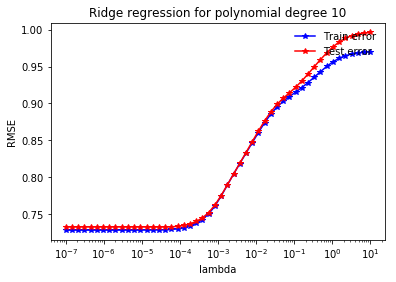

In [37]:
weights_no_nan, degree_no_nan, lambda_no_nan = test_ridge_regression(
    x_no_nan, y_train, x_no_nan_val, y_validation, degrees = np.linspace(9,11,3), lambdas=np.logspace(-7,1,50))

## Submission


In [38]:
y_test, x_test, ids_test, header = helper.load_csv_data(DATA_TEST)
x_test[x_test == -999] = np.nan

x_no_nan_test = x_test.copy()
x_no_nan_test = normalize_outliers_feed(x_no_nan_test, mean_train, std_train)
# x_no_nan_test = (x_no_nan_test - np.nanmedian(x_no_nan_test, axis=0))/mad(x_no_nan_test)
x_no_nan_test = np.nan_to_num(x_no_nan_test)
print('\nStd:', np.std(x_no_nan_test, axis=0))


Std: [ 0.9353  1.0276  1.0166  1.0386  0.5507  0.5577  0.5367  1.0136  1.0362
  1.0425  1.038   1.0015  0.5385  1.0164  0.9997  0.9995  1.0263  1.0002
  0.9996  1.0289  0.9999  1.0466  1.0007  0.8013  0.7716  0.7751  0.5523
  0.5391  0.539   1.0403]


In [39]:
degree_opt = degree_no_nan
weights_opt = weights_no_nan

_phi_test = lib.build_poly(x_no_nan_test, degree_opt)
y_pred = helper.predict_labels(weights_opt, _phi_test)

In [40]:
helper.create_csv_submission(ids_test, y_pred, 'ridge_no_nan1.csv')
print('Results saved ...')

Results saved ...


In [ ]:
weights_no_nan